# Bike sharing demand prediction

Provided hourly rental data spanning two years, predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. 

In [135]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, ensemble, pipeline, metrics

In [136]:
data_test, data_train = pd.read_csv('test.csv'), pd.read_csv('train.csv')
data_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [137]:
datetimecol = data_test['datetime']

In [138]:
print("Shape of the train dataset: ", data_train.shape)
print("Shape of the test dataset: ", data_test.shape)

Shape of the train dataset:  (10886, 12)
Shape of the test dataset:  (6493, 9)


In [139]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [140]:
# transofrm object to datetime for future manipulations

data_train['datetime'] = data_train['datetime'].apply(pd.to_datetime)

## Feature engineering

Fortunately, we have no missing values to deal with.

In [141]:
print(data_train.isnull().values.any())
print(data_test.isnull().values.any())

False
False


First, let's transform *datetime* column to *month* and *hour* features

In [142]:
data_train['month'] = data_train.datetime.apply(lambda x : x.month)
data_train['hour'] = data_train.datetime.apply(lambda x : x.hour)

# getting rid of datetime since we don't need it anymore
data_train.drop(['datetime'], axis=1, inplace=True)

Next, let's see how features are correlated:

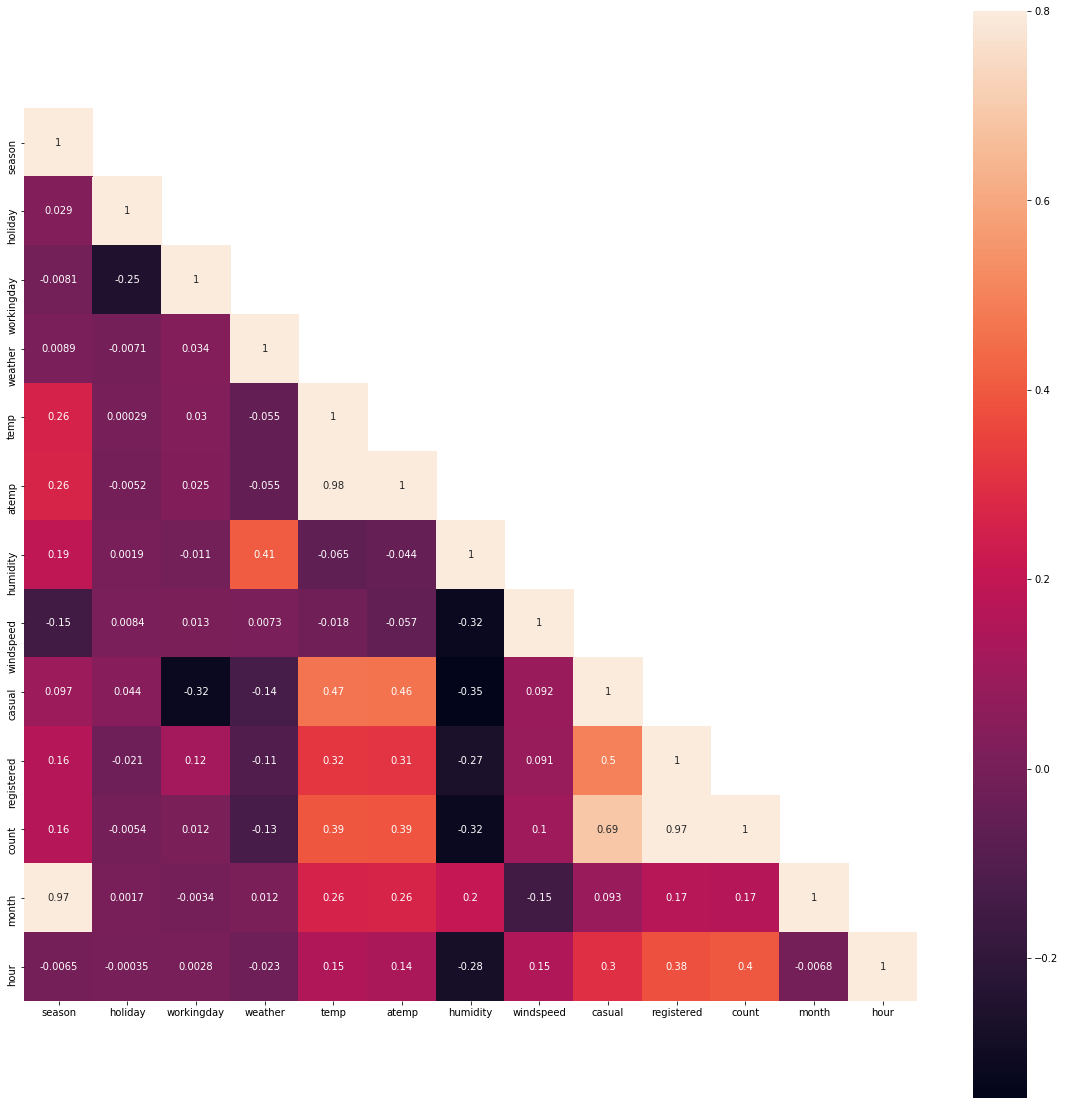

In [143]:
corrMatt = data_train.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

As we can see, "registered" and "casual" variables are highly correlated with our target variable "count", what is obvious based on our description. We should drop them later. Count is also correlated with "temp" and "atemp".

In [144]:
yLabel = data_train['count']

In [146]:
drop_features = ['registered', 'casual', 'count']
data_train.drop(drop_features, axis=1, inplace=True)

In [147]:
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'month', 'hour']
categorical_indices = np.array([(column in categorical_features) for column in data_train.columns], dtype = bool)
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
numerical_indices = np.array([(column in numerical_features) for column in data_train.columns], dtype = bool)

In [148]:
data_test['datetime'] = data_test['datetime'].apply(pd.to_datetime)
data_test['month'] = data_test.datetime.apply(lambda x : x.month)
data_test['hour'] = data_test.datetime.apply(lambda x : x.hour)
data_test.drop(['datetime'], axis=1, inplace=True)

## Building a model 

In [149]:
regressor = ensemble.RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [150]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [         
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numerical_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [151]:
estimator.fit(data_train, yLabel)

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_variables_processing', Pipeline(memory=None,
     steps=[('selecting', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7fe6401d8598>, inv_kw_args=None,
          inverse_func=None,..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [154]:
counts = estimator.predict(data_test)

In [156]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": counts
    })


In [158]:
submission.to_csv('bike_predictions.csv', index=False)